In [2]:
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import newick
from copy import deepcopy
import math
from itertools import chain
from collections import deque

# Kódok

In [16]:


#ezeket választjuk ki osztódásra: bemenetek: l-kezdeti list, k-hányat választunk ki
def choose_from_population(l, k):
    """
    Kiválaszt a populációból k sejtet
    params:
    l: list, bemeneti populáció
    k: int, hányat sejtet válasszunk ki osztódásra
    """
    chosen_samples=rd.sample(range(len(l)),k)
    return chosen_samples

#sejtek elpusztítása
def kill(duplicated_list,for_death):
    """
    A megadott indexű elemeket kitörli a populációból
    params:
    duplicated_list: list, azon populáció, amelyben már osztódtak a sejtek
    for_death: list, azokat az indexeket tartalmazza, amiket ki kell hagyni
    """

    result2=[]
    for i in range(len(duplicated_list)):
        if i not in for_death:    
            result2.append(duplicated_list[i])
    return result2

def duplication_and_mutation_100(culture, for_duplication, m):
    """
    A populációból a kiválasztott sejteket osztatja és  biztosan ad mutációkat is ad az új sejtekhez
    params:
    culture: list, a populációt tartalmazza
    for_duplication: list, azon sejtek indexei, amelyeket osztódnak
    m: int, kezdeti mutáció száma. Érdemes 1-el indítani


    """
    
    after_duplication=[]
    for i in range(len(culture)):
        mutates=[]
        if i in for_duplication:
            mutates.append(deepcopy(culture[i]))
            mutates.append(deepcopy(culture[i]))  
            for j in range(2):
                mutates[j].append(m)   
                m = m+1
                after_duplication.append(deepcopy(mutates[j]))   
        else:
            after_duplication.append(deepcopy(culture[i]))
    return after_duplication,m

#sejtek osztódása és mutációk gyűjtése
def duplication_and_mutation(culture, for_duplication, m, mutation_number_expected_value):
    """
    A populációból a kiválasztott sejteket osztatja és mutációkat is ad az új sejtekhez
    params:
    culture: list, a populációt tartalmazza
    for_duplication: list, azon sejtek indexei, amelyeket osztódnak
    m: int, kezdeti mutáció száma. Érdemes 1-el indítani
    mutation_number_expected_value: int, a poisson eloszlás a várható értéke

    """

    after_duplication=[]
    for i in range(len(culture)):
        mutates=[]
        if i in for_duplication:
            mutates.append(deepcopy(culture[i]))
            mutates.append(deepcopy(culture[i]))  
            for j in range(2):
                mut_num = np.random.poisson(mutation_number_expected_value)
                if mut_num != 0:
                    for l in range(mut_num):
                        mutates[j].append(m)   
                        m = m+1
                    after_duplication.append(deepcopy(mutates[j]))
                else:
                    after_duplication.append(deepcopy(mutates[j]))    
        else:
            after_duplication.append(deepcopy(culture[i]))
    return after_duplication,m



def decider(n):
    """
    Ez a fv két számot ad vissza, hányszor kell duplázni a sejteket ágképzésnél és hány sejtet kell még 1-szer osztatni.
    params: 
    n: int
    """

    k = 0
    while 2**(k+1)<=n:
        k += 1
    r = n-pow(2,k)
    return k,r

def creating_buds_random(after_moran, n, rds_bud:deque):
    """
    Ez a fv random kiveszi az osztódás utáni populáció egyik tagját.
    params:
    after_moran: list, a Moran lépés utáni listát kapja meg
    n: int, populációméret
    """
    #print(after_moran)
    a = rds_bud.popleft()
    #print(a)
    leolt = kill(after_moran, [a]) 
    #print(leolt)
    bud = after_moran[a] #ide ugyanazt a számot beírni, mint egy sorral feljebb.
    return (leolt, bud)


#ez pedig az osztódás rész
def propagation(n,single_cell, starter_mutation, mutation_number_expected_value, rds_prop:deque): 
    """
    Az ágképzést valósítja meg. 1 sejtből csinál n sejtet.
    params:
    n: int, populáció mérete
    single_cell: list, 1 sejt, amit megkap az ágból
    starter_mutation: int, kezdeti mutációs szám
    mutation_number_expected_value: int, a poisson eloszlás a várható értéke
    """

    bemenet=deepcopy(single_cell)
    mutate_m=starter_mutation
    for i in range(decider(n)[0]):
        #print('Culture:', bemenet)
        #print(bemenet)
        valasztott=choose_from_population(bemenet,len(bemenet))
        #print(valasztott)
        kettozott_es_mutalt, mutate_m=duplication_and_mutation_100(bemenet,valasztott, mutate_m)
        #print(kettozott_es_mutalt)
        bemenet=deepcopy(kettozott_es_mutalt)
        #print('Culture:', bemenet)
    valasztott = rds_prop.popleft()
    
    #print(valasztott)
    kettozott_es_mutalt, mutate_m=duplication_and_mutation_100(bemenet, valasztott, mutate_m)
    #print(kettozott_es_mutalt)
    bemenet=deepcopy(kettozott_es_mutalt)
    #print(bemenet)
    last_mutation=mutate_m
    return(bemenet, last_mutation)


    
def simulate(to, n, starter_culture, starter_mutation, moran_steps_in_a_year, mutation_number_expected_value, rds, rds_prop, rds_bud): 
    """
    két elágazás közt végigmegy a szimuláció. Ha mellékág kezdődik, akkor először felsokszorozza a sejteket, majd megy tovább
    params:
    to: int, évek száma.
    n: int, sejtpopuláció mérete
    starter_culture: list, kezdeti populáció. 
    starter_mutation: int, kezdeti mutációs szám
    moran_steps_in_a_year: int, 1 év alatt hány lépést tegyen a szimuláció, azaz hány rügyet rakjon le. Összes lépés = to*moran_steps_in_a_year
    mutation_number_expected_value: int, a poisson eloszlás a várható értéke
    rds: list, tartalmazza a random számokat a fa létrehozására
    """
    
    mutate_m = starter_mutation
    culture = deepcopy(starter_culture)
    branching_buds = []
    #print('Kezdeti populáció:', culture)
    lim = to
    if len(culture) == 1:
        culture, mutate_m=propagation(n,culture,mutate_m, mutation_number_expected_value, rds_prop)
    for i in range(moran_steps_in_a_year * lim):
        #print('\n','Populáció a(z)', i+1,'. Moran lépés kezdetén', culture)
        k = 1

        choices = rds.popleft()
        #print('Sorszám osztódásra:',choices)
        duplicated_and_mutated, mutate_m = duplication_and_mutation_100(culture, choices, mutate_m)
        #print('Megkettőződtek és mutáltak',duplicated_and_mutated)

        #after_creating_buds = deepcopy(creating_buds_random(duplicated_and_mutated, n)[0])
        #print('Rügyképzés után:',after_creating_buds)  
        #if i == moran_steps_in_a_year * lim - 1:
        #    branching_buds=[deepcopy(creating_buds_random(duplicated_and_mutated, n)[1])]
        v1 , v2 = creating_buds_random(duplicated_and_mutated, n, rds_bud)
        after_creating_buds = deepcopy(v1)
        #print('Rügyképzés után:',after_creating_buds)  
        if i == moran_steps_in_a_year * lim - 1:
            branching_buds=[deepcopy(v2)]
        culture=deepcopy(after_creating_buds)
    #print('Kimeneti populáció', culture)
    #print('Rügy:', branching_buds)
    next_mutation = mutate_m
    return culture, branching_buds,next_mutation


def DFS(
    node,
    n: int,
    last_node_name: list,
    last_node_children_number: int,
    brain_list: list,
    starter_list: list,
    results: list,
    end_of_branch: list,
    moran_steps_in_a_year: int,
    mutation_number_expected_value: float,
    rds: list,
    rds_prop: list,
    rds_bud: list,
):
    """
    Ez a fv az all in all, végigmegy az egész fán depth-first search algoritmussal, megcsinál minden Moran-lépést, ágképzést.
    params:
    node: a Newick-könyvtárral beolvasott fa-struktúra. 
    n: int, populációméret.
    last_node_name: list, az utolsó elágazási pont neve. Rekurzív a DFS fv, így [None]-t kell megadni kezdeti értéknek.
    last_node_children_number: int, az utolsó nód után hány ág van. Kezdeti érték legyen [1]
    brain_list: list, mindig a fő ág szimulációjának eredményét tartalmazza. Pl. végigmegy egy mellékágon, ami után már nincs több elágazás, visszaugrásnál
    kiveszi a lista utolsó elemét és azzal megy tovább.
    starter_list: list, kezdeti populáció. [[]]*n legyen
    results: list, a sim fv eredményeit adja vissza, [] kezdetben
    end_of_branch: list, az ág végén lévő populációt adja vissza (n sejt a mutációkkal)
    moran_steps_in_a_year: int, 1 év alatt hány lépést tegyen a szimuláció, azaz hány rügyet rakjon le. Összes lépés = to*moran_steps_in_a_year
    mutation_number_expected_value: int, a poisson eloszlás a várható értéke

    """
    lengths = []
    last_node_name.append(node.name)
    a = node.length
    children = node.descendants[::-1]
    last_node_children_number.append(len(children))

    if len(children) == 2 and last_node_children_number[-2] == 2:
        res = simulate(int(a), n , starter_list[1], starter_list[2], moran_steps_in_a_year, mutation_number_expected_value, rds, rds_prop, rds_bud)
        starter_list[0] = res[0]
        starter_list[1] = res[1]
        starter_list[2] = res[2]
        results.append(res)
        brain_list.append(res[0])

    elif len(children) == 2 and last_node_children_number[-2] == 1:
        res = simulate(int(a), n , starter_list[0], starter_list[2], moran_steps_in_a_year, mutation_number_expected_value, rds, rds_prop, rds_bud)
        starter_list[0] = res[0]
        starter_list[1] = res[1]
        starter_list[2] = res[2]
        results.append(res)
        brain_list.append(res[0])

    elif len(children) == 1 and last_node_children_number[-2] == 2:
        res = simulate(int(a), n , starter_list[1], starter_list[2], moran_steps_in_a_year, mutation_number_expected_value, rds, rds_prop, rds_bud)
        starter_list[0] = res[0]
        starter_list[1] = res[1]
        starter_list[2] = res[2]

    elif len(children) == 1 and last_node_children_number[-2] == 1:
        res = simulate(int(a), n , starter_list[0], starter_list[2], moran_steps_in_a_year, mutation_number_expected_value, rds, rds_prop, rds_bud)
        starter_list[0] = res[0]
        starter_list[1] = res[1]
        starter_list[2] = res[2]

    elif len(children) == 2 and last_node_children_number[-2] == 0:
        res = simulate(int(a), n , brain_list[-1], starter_list[2], moran_steps_in_a_year, mutation_number_expected_value, rds, rds_prop, rds_bud)
        starter_list[0] = res[0]
        starter_list[1] = res[1]
        starter_list[2] = res[2]
        results.append(res)
        if len(brain_list) != 0:
            brain_list.pop() 
        brain_list.append(res[0])


    elif len(children) == 1 and last_node_children_number[-2] == 0: 
        res = simulate(int(a), n , brain_list[-1], starter_list[2], moran_steps_in_a_year, mutation_number_expected_value, rds, rds_prop, rds_bud)
        starter_list[0] = res[0]
        starter_list[1] = res[1]
        starter_list[2] = res[2]
        if len(brain_list) != 0:
            brain_list.pop() 
    
    elif len(children) == 0 and last_node_children_number[-2] == 0:
        res = simulate(int(a), n , brain_list[-1], starter_list[2], moran_steps_in_a_year, mutation_number_expected_value, rds, rds_prop, rds_bud)
        starter_list[0] = res[0]
        starter_list[1] = res[1]
        starter_list[2] = res[2]
        results.append(res)
        end_of_branch.append(res[0])
        if len(brain_list) != 0:
            brain_list.pop() 
    
    elif len(children) == 0 and last_node_children_number[-2] == 1:
        res = simulate(int(a), n , starter_list[0], starter_list[2], moran_steps_in_a_year, mutation_number_expected_value, rds, rds_prop, rds_bud)
        starter_list[0] = res[0]
        starter_list[1] = res[1]
        starter_list[2] = res[2]
        results.append(res)
        end_of_branch.append(res[0])
    
    elif len(children) == 0 and last_node_children_number[-2] == 2: 
        res = simulate(int(a), n , starter_list[1], starter_list[2], moran_steps_in_a_year, mutation_number_expected_value, rds, rds_prop, rds_bud)
        starter_list[0] = res[0]
        starter_list[1] = res[1]
        starter_list[2] = res[2]
        results.append(res)
        end_of_branch.append(res[0])
    
    lengths.append(a)
    for descendants in node.descendants[::-1]:

        kisebb_fa=DFS(descendants, n, last_node_name, last_node_children_number, brain_list, starter_list, results, end_of_branch, moran_steps_in_a_year, mutation_number_expected_value, rds, rds_prop, rds_bud)

    return end_of_branch

def flatten_chain(matrix):
    return list(chain.from_iterable(matrix))

def remove(my_list, my_set):
    for element in my_set:
        if element in my_list:
            my_list.remove(element)
    return my_list

def fun(nested_list):

    list1 = nested_list[0]
    list2 = nested_list[1]
    list3 = nested_list[2]
    list4 = nested_list[3]

    set1 = set(list1)
    set2 = set(list2)
    set3 = set(list3)
    set4 = set(list4)

    found_in_all = set1 & set2 & set3 & set4
    num_found_in_all = len(found_in_all)
    set1.difference_update(found_in_all)
    set2.difference_update(found_in_all)
    set3.difference_update(found_in_all)
    set4.difference_update(found_in_all)

    found_in_123 = set1 & set2 & set3
    num_found_in_123 = len(found_in_123)
    set1.difference_update(found_in_123)
    set2.difference_update(found_in_123)
    set3.difference_update(found_in_123)

    found_in_124 = set1 & set2 & set4
    num_found_in_124 = len(found_in_124)
    set1.difference_update(found_in_124)
    set2.difference_update(found_in_124)
    set4.difference_update(found_in_124)

    found_in_134 = set1 & set3 & set4
    num_found_in_134 = len(found_in_134)
    set1.difference_update(found_in_134)
    set3.difference_update(found_in_134)
    set4.difference_update(found_in_134)

    found_in_234 = set2 & set3 & set4
    num_found_in_234 = len(found_in_234)
    set2.difference_update(found_in_234)
    set3.difference_update(found_in_234)
    set4.difference_update(found_in_234)

    found_in_12 = set1 & set2
    num_found_in_12 = len(found_in_12)
    set1.difference_update(found_in_12)
    set2.difference_update(found_in_12)

    found_in_13 = set1 & set3
    num_found_in_13 = len(found_in_13)
    set1.difference_update(found_in_13)
    set3.difference_update(found_in_13)

    found_in_14 = set1 & set4
    num_found_in_14 = len(found_in_14)
    set1.difference_update(found_in_14)
    set4.difference_update(found_in_14)

    found_in_23 = set2 & set3
    num_found_in_23 = len(found_in_23)
    set2.difference_update(found_in_23)
    set3.difference_update(found_in_23)

    found_in_24 = set2 & set4
    num_found_in_24 = len(found_in_24)
    set2.difference_update(found_in_24)
    set4.difference_update(found_in_24)

    found_in_34 = set3 & set4
    num_found_in_34 = len(found_in_34)
    set3.difference_update(found_in_34)
    set4.difference_update(found_in_34)

    found_in_1 = set1
    num_found_in_1 = len(found_in_1)
    found_in_2 = set2
    num_found_in_2 = len(found_in_2)
    found_in_3 = set3
    num_found_in_3 = len(found_in_3)
    found_in_4 = set4
    num_found_in_4 = len(found_in_4)

    return num_found_in_1, num_found_in_2, num_found_in_3, num_found_in_4, num_found_in_12, num_found_in_13, num_found_in_14, num_found_in_23, num_found_in_24, num_found_in_34, num_found_in_123, num_found_in_124, num_found_in_134, num_found_in_234, num_found_in_all



def pairing(l_14, l_13):
    """
    A szimuláció eredményeit párosítja össze a tree_13-ra és a tree_14-re.
    params:
    l_14: tree_14-es fa szimulációjának eredménye
    l_13: tree_13-es fa szimulációjának eredménye
    """

    y = [ 0, #l_14[0], l_14[1], l_14[2], l_14[3],
            #l_13[0], l_13[1], l_13[2], l_13[3],
            l_14[4], l_14[5], l_14[6], l_14[7], l_14[8], l_14[9],
            l_13[4], l_13[5], l_13[6], l_13[7], l_13[8], l_13[9],
            l_14[10], l_14[11], l_14[12], l_14[13],
            l_13[10], l_13[11], l_13[12], l_13[13],
            #l_14[14],
            #l_13[14]
            ]
    return y

def plotting(tree_14, tree_13,):

    """
    A plottolást valósítja meg. bar plotot készít, amelyen szerepel a szimuláció eredménye és a mért adatok is.

    """
    fig, ax = plt.subplots(1, figsize=(12, 5))

    x_values = ['[1,2,3,4,5,6,7,8]',
                #'[1,0,0,0,0,0,0,0]', '[0,1,0,0,0,0,0,0]', '[0,0,1,0,0,0,0,0]', '[0,0,0,1,0,0,0,0]',
                #'[0,0,0,0,1,0,0,0]', '[0,0,0,0,0,1,0,0]', '[0,0,0,0,0,0,1,0]', '[0,0,0,0,0,0,0,1]',
                '[1,1,0,0,0,0,0,0]', '[1,0,1,0,0,0,0,0]', '[1,0,0,1,0,0,0,0]', '[0,1,1,0,0,0,0,0]', '[0,1,0,1,0,0,0,0]', '[0,0,1,1,0,0,0,0]',
                '[0,0,0,0,1,1,0,0]', '[0,0,0,0,1,0,1,0]', '[0,0,0,0,1,0,0,1]', '[0,0,0,0,0,1,1,0]', '[0,0,0,0,0,1,0,1]', '[0,0,0,0,0,0,1,1]',
                '[1,1,1,0,0,0,0,0]', '[1,1,0,1,0,0,0,0]', '[1,0,1,1,0,0,0,0]', '[0,1,1,1,0,0,0,0]',
                '[0,0,0,0,1,1,1,0]', '[0,0,0,0,1,1,0,1]', '[0,0,0,0,1,0,1,1]', '[0,0,0,0,0,1,1,1]',
                #'[1,1,1,1,0,0,0,0]',
                #'[0,0,0,0,1,1,1,1]'
                ]
    width = 0.45
    x_positions = np.arange(len(x_values))
    #y_values = [0, 12, 47, 30, 31, 25, 21, 34, 22, 0, 0, 1, 1, 1, 8, 0, 0, 0, 1, 0, 4, 0, 0, 0, 3, 0, 0, 0, 3, 0, 0 ]
    y_values = [0, 0, 0, 1, 1, 1, 8, 0, 0, 0, 1, 0, 4, 0, 0, 0, 3, 0, 0, 0, 3 ]
    y_values_sim = pairing(tree_14, tree_13)
    #y_values_sim = pairing(np.array(tree_14), np.array(tree_13))

    for i in range(1,21):
        ax.text(x_positions[i] - width/2, y_values[i] + 0.3, f'{y_values[i]:.3f}', ha='center', va='bottom', fontsize=10, color='black', rotation=90)
        ax.text(x_positions[i] + width/2, y_values_sim[i] + 0.3, f'{y_values_sim[i]:.3f}', ha='center', va='bottom', fontsize=10, color='black', rotation=90)  

    bar1 = ax.bar(x_positions - width/2, y_values, width, color = 'green', label = 'Original data')
    bar2 = ax.bar(x_positions + width/2, y_values_sim, width, color = 'yellow', label = 'Simulation')
    ax.set_xticks(x_positions)
    ax.set_xticklabels(x_values, rotation = 90)
    for y_value in range(1, math.ceil(max(y_values))+1):
        ax.axhline(y = y_value, color = 'gray', linestyle = '--', linewidth=0.5)
    ax.set_title(f'Tuti kap mutációt, Merisztéma populáció: 7 sejt, Moran lépések száma: 1, random kivétel')
    ax.set_ylabel('SNPs')
    ax.legend()
    #plt.savefig('Random_kivétel_5_sejt', format = 'png')
    plt.show()


def loglikelihood(mu, f, k):
    L = np.log(mu)*np.sum(k) + np.sum(k*np.log(f)) - mu*np.sum(f)
    return L

def randoms(n, moran_steps, num_of_sim):
    prop = []
    v = int(np.power(2, np.floor(math.log(n, 2))))
    dupl = rd.choices(range(n), k = 804 * moran_steps * num_of_sim)
    for i in range(8 * num_of_sim):
        prop.append(rd.sample(range(v), n-v))
    bud = rd.choices(range(n), k = 804 * moran_steps * num_of_sim)

    return dupl, prop, bud

In [7]:
d, p, b = randoms(n = 7, moran_steps = 1, num_of_sim = 1000)

randoms1 = deque([[x] for x in d])
randoms2 = deque(p)
randoms3 = deque(b)

with open("sajt.txt", "w") as file:
    # Write all elements of the list to the file
    file.write("\n".join(map(str, d)))

with open("sajt2.txt", "w") as file:
    # Write all elements of the list to the file
    file.write("\n".join(map(str, p)))

with open("sajt3.txt", "w") as file:
    # Write all elements of the list to the file
    file.write("\n".join(map(str, b))) 

In [8]:
print(randoms2)

deque([[0, 1, 2], [2, 1, 0], [1, 2, 0], [2, 3, 1], [3, 1, 0], [3, 0, 1], [2, 1, 3], [3, 2, 0], [1, 3, 0], [3, 0, 1], [2, 1, 3], [1, 0, 2], [1, 0, 2], [0, 2, 3], [0, 2, 1], [3, 0, 2], [1, 3, 0], [2, 1, 3], [3, 0, 1], [1, 0, 2], [1, 0, 2], [3, 2, 0], [1, 3, 2], [3, 1, 0], [1, 2, 3], [0, 2, 3], [0, 2, 3], [0, 1, 3], [1, 0, 2], [2, 0, 1], [3, 0, 2], [1, 0, 3], [0, 1, 2], [2, 3, 1], [1, 2, 3], [2, 0, 1], [2, 0, 1], [3, 0, 1], [1, 2, 0], [0, 2, 3], [1, 2, 0], [2, 0, 1], [2, 0, 3], [3, 0, 1], [0, 2, 3], [1, 0, 3], [2, 0, 3], [3, 2, 1], [0, 2, 1], [3, 1, 0], [3, 1, 0], [0, 1, 2], [0, 2, 1], [3, 2, 0], [3, 2, 1], [1, 2, 3], [1, 0, 2], [0, 3, 1], [1, 0, 2], [1, 0, 3], [0, 2, 1], [0, 2, 3], [3, 1, 2], [1, 2, 0], [1, 3, 0], [3, 1, 0], [3, 0, 1], [2, 0, 3], [3, 0, 2], [1, 2, 3], [2, 0, 1], [1, 3, 0], [3, 2, 0], [0, 2, 1], [0, 3, 1], [0, 1, 2], [2, 1, 3], [2, 0, 3], [3, 1, 0], [1, 3, 0], [3, 2, 1], [3, 2, 1], [0, 2, 1], [3, 2, 1], [0, 2, 3], [0, 1, 3], [0, 3, 1], [1, 2, 0], [2, 0, 1], [2, 1, 3], [0,

In [9]:

"""
Newick-fa inicializálása a Hofmeister et. al 2019 cikk alapján.
"""
newick_tree=''' ((Törzs:28,((((13.1:29):13,13.2:41):28,13.3:70):41,13.5:80):60):1,((((14.2:35):6,14.3:41):36,14.4:40):32,14.5:72):150):1'''
# példa futtatás:


In [10]:
tree_13_res = np.zeros(15)
tree_14_res = np.zeros(15)

for i in range(1000):
    sim = DFS(node = newick.loads(newick_tree)[0], n = 7, last_node_name = [None], last_node_children_number = [1], brain_list = [], starter_list = [[[]]*7,[], 1], results = [], end_of_branch = [], moran_steps_in_a_year = 1, mutation_number_expected_value = 1, rds = randoms1, rds_prop = randoms2, rds_bud = randoms3)
    sim.pop()
    tree_14_mut = [rd.choice(sim[0]), rd.choice(sim[1]), rd.choice(sim[2]), rd.choice(sim[3])]
    tree_13_mut = [rd.choice(sim[4]), rd.choice(sim[5]), rd.choice(sim[6]), rd.choice(sim[7])]
    tree_14_res += np.array(fun(tree_14_mut))
    tree_13_res += np.array(fun(tree_13_mut))

avg_tree_14 = tree_14_res/1000
avg_tree_13 = tree_13_res/1000


In [43]:
print(avg_tree_14, avg_tree_13)
f_i = np.array(pairing(avg_tree_14, avg_tree_13)[1::])
print(f_i)
f = sum(np.array(f_i).transpose())
print(f)
#mus = np.zeros((4,8))
mu = sum(k_i)/f
print(mu)
#logL = []
#a = 0

#print(np.array(fs))


a = np.array(f_i)
print(a)
rows_with_zero = np.any(a == 0, axis=0) #több dim esetén axis = 1
print(rows_with_zero)
a = a[~rows_with_zero]
print(a)
f = sum(np.array(f_i).transpose())
#f2 = sum(a.transpose())
k_i = np.array([0, 0, 1, 1, 1, 8, 0, 0, 0, 1, 0, 4, 0, 0, 0, 3, 0, 0, 0, 3])
mus = sum(k_i)/f
print(mus)
#mus2 = sum(k_i)/f2
#print(mus)
#print(mus)
logL = []
#print('Valami',np.shape(a), a)
for i in range(1):
    logL.append(loglikelihood(mus, np.array(a)[i], k_i )) 
print(logL)
#L = new_list = [-15 if flag else logL.pop(0) for flag in rows_with_zero]
#print(L)

[26.073 19.23  19.853 14.927  2.427  0.278  0.281  1.574  0.626  6.553
  0.651  0.268  0.793  5.122 16.675] [26.027 23.92  19.191 14.821  1.066  0.297  0.148  2.029  0.794  5.128
  0.659  0.099  0.501  5.355  5.634]
[2.427 0.278 0.281 1.574 0.626 6.553 1.066 0.297 0.148 2.029 0.794 5.128
 0.651 0.268 0.793 5.122 0.659 0.099 0.501 5.355]
34.649
0.634938959277324
[2.427 0.278 0.281 1.574 0.626 6.553 1.066 0.297 0.148 2.029 0.794 5.128
 0.651 0.268 0.793 5.122 0.659 0.099 0.501 5.355]
False
[[2.427 0.278 0.281 1.574 0.626 6.553 1.066 0.297 0.148 2.029 0.794 5.128
  0.651 0.268 0.793 5.122 0.659 0.099 0.501 5.355]]
0.634938959277324
[-1.0566497330381566]


[2.427 0.278 0.281 1.574 0.626 6.553 1.066 0.297 0.148 2.029 0.794 5.128
 0.651 0.268 0.793 5.122 0.659 0.099 0.501 5.355]
[0 0 1 1 1 8 0 0 0 1 0 4 0 0 0 3 0 0 0 3]
[ 0.     0.     0.281  1.574  0.626 52.424  0.     0.     0.     2.029
  0.    20.512  0.     0.     0.    15.366  0.     0.     0.    16.065]


In [55]:
print(np.log(mus)*sum(k_i)+sum(k_i*(np.log(f_i)))-mus*sum(f_i))

-1.0566497330381566


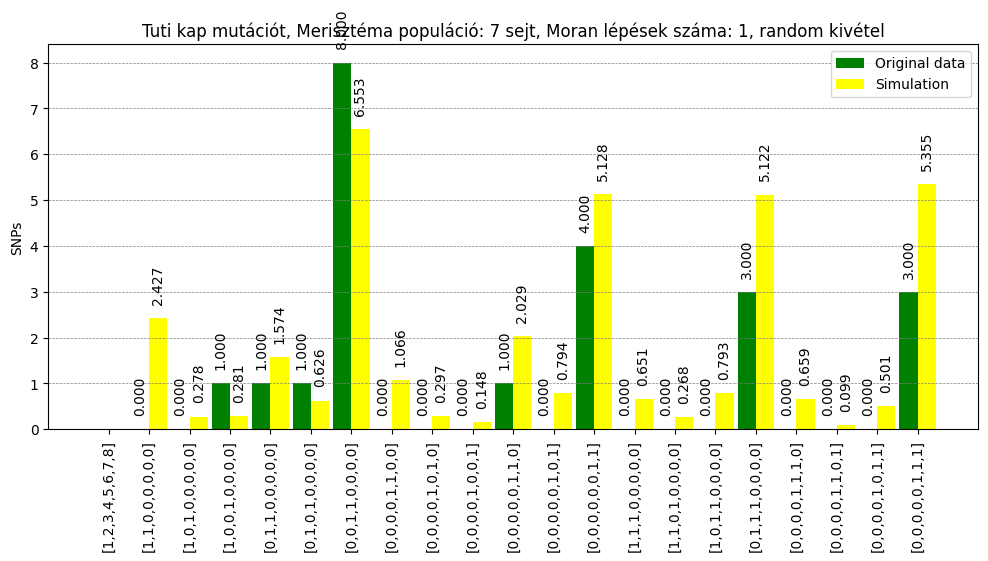

In [17]:
plotting(avg_tree_14, avg_tree_13)

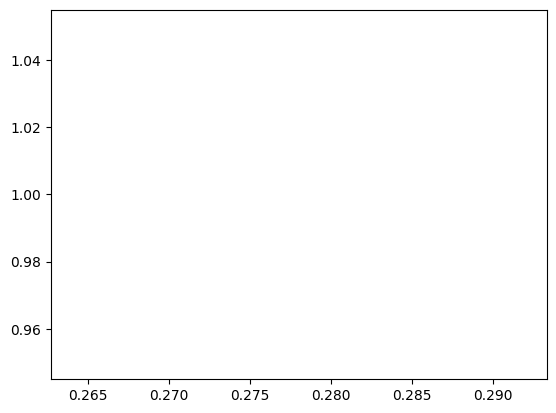

In [30]:
unique_elements, counts = np.unique(avg_tree_14[5], return_counts=True)

plt.plot(unique_elements, counts)

In [22]:
f_i = pairing(avg_tree_14, avg_tree_13)[1::]
k_i = [0, 0, 1, 1, 1, 8, 0, 0, 0, 1, 0, 4, 0, 0, 0, 3, 0, 0, 0, 3 ]
mu = sum(k_i)/sum(f_i)
print(mu)


0.6384028321871099


In [ ]:
d, p, b = randoms(n = 7, moran_steps = 1, num_of_sim = 1000)

randoms1 = deque([[x] for x in d])
randoms2 = deque(p)
randoms3 = deque(b)

with open("sajt.txt", "w") as file:
    # Write all elements of the list to the file
    file.write("\n".join(map(str, d)))

with open("sajt2.txt", "w") as file:
    # Write all elements of the list to the file
    file.write("\n".join(map(str, p)))

with open("sajt3.txt", "w") as file:
    # Write all elements of the list to the file
    file.write("\n".join(map(str, b))) 

In [5]:
"""
Futtatás, változtatva a merisztéma populáció méretét:
"""
final_tree_14 = np.zeros((4,8,15))
final_tree_13 = np.zeros((4,8,15))


N = [2,6,10,14,18,22,26,30]
M = [1,2,4,8]

for k in M:
    for j in N:

        d, p, b = randoms(n = j, moran_steps = k, num_of_sim = 50)
        randoms1 = deque([[x] for x in d])
        randoms2 = deque(p)
        randoms3 = deque(b)

        tree_13_res = np.zeros(15)
        tree_14_res = np.zeros(15)
        for i in range(50):
            sim = DFS(node = newick.loads(newick_tree)[0],
                    n = j,
                    last_node_name = [None],
                    last_node_children_number = [1],
                    brain_list = [], 
                    starter_list = [[[]]*j,[], 1], 
                    results = [], 
                    end_of_branch = [], 
                    moran_steps_in_a_year = k, 
                    mutation_number_expected_value = 1, 
                    rds = randoms1, 
                    rds_prop = randoms2, 
                    rds_bud = randoms3)
            sim.pop()
            tree_14_mut = [rd.choice(sim[0]), rd.choice(sim[1]), rd.choice(sim[2]), rd.choice(sim[3])]
            tree_13_mut = [rd.choice(sim[4]), rd.choice(sim[5]), rd.choice(sim[6]), rd.choice(sim[7])]
            tree_14_res += np.array(fun(tree_14_mut))
            tree_13_res += np.array(fun(tree_13_mut))

        avg_tree_14 = tree_14_res/50
        avg_tree_13 = tree_13_res/50
        
        w = (j-2)/4 
        u = int(math.log(k,2))

        final_tree_14[u][int(w)] = avg_tree_14
        final_tree_13[u][int(w)] = avg_tree_13


# Elvileg a következő cella iszámolja a loglikelihood értékeket, de ellenőrizni kell.

In [9]:
fs = []
for j in range(4):
    for i in range(8):
        fs.append(np.array(pairing(final_tree_14[j][i], final_tree_13[j][i])[1::]))
#print(np.array(fs))
f = sum(np.array(fs).transpose())
k_i = np.array([0, 0, 1, 1, 1, 8, 0, 0, 0, 1, 0, 4, 0, 0, 0, 3, 0, 0, 0, 3])
mus = np.zeros((4,8))
mus = sum(k_i)/f
print(mus)
logL = []
a = 0

print(np.array(fs))

#for i in range(32):
#    logL.append(loglikelihood(mus[i], np.array(fs)[i], k_i )) 
#print(logL)


[0.31921068 0.66747573 0.71428571 0.68365444 0.79537238 0.90163934
 1.04562738 1.17021277 0.16267377 0.4587156  0.42868277 0.46257359
 0.52231719 0.54563492 0.59556037 0.65243179 0.07958327 0.24509804
 0.31187978 0.30829596 0.27281746 0.31064671 0.35132546 0.36030134
 0.04028714 0.12066696 0.20065669 0.22231205 0.21666338 0.20109689
 0.21938572 0.24504344]
[[0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.7900e+01
  0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 0.0000e+00 1.4420e+01
  0.0000e+00 0.0000e+00 0.0000e+00 1.6100e+01 0.0000e+00 0.0000e+00
  0.0000e+00 2.0500e+01]
 [2.8200e+00 0.0000e+00 0.0000e+00 8.8000e-01 1.2000e-01 8.3400e+00
  1.1200e+00 0.0000e+00 0.0000e+00 1.0400e+00 6.4000e-01 5.3800e+00
  0.0000e+00 1.2000e-01 6.2000e-01 5.3200e+00 4.0000e-02 0.0000e+00
  0.0000e+00 6.5200e+00]
 [1.2400e+00 2.8000e-01 3.0000e-01 1.5400e+00 1.6600e+00 3.9600e+00
  5.0000e-01 5.4000e-01 2.0000e-02 2.1200e+00 1.2000e+00 4.0600e+00
  2.0200e+00 1.1000e+00 8.6000e-01 4.6400e+00 5

In [62]:
#print(np.array(fs))
a = np.array(fs)
rows_with_zero = np.any(a == 0, axis=1)
print(rows_with_zero)
a = a[~rows_with_zero]
f = sum(np.array(fs).transpose())
f2 = sum(a.transpose())
k_i = np.array([0, 0, 1, 1, 1, 8, 0, 0, 0, 1, 0, 4, 0, 0, 0, 3, 0, 0, 0, 3])
mus = np.zeros
print(mus)
mus = sum(k_i)/f
mus2 = sum(k_i)/f2
print(mus)
#print(mus)
logL = []
#print('Valami',np.shape(a), a)
for i in range(15):
    logL.append(loglikelihood(mus2[i], np.array(a)[i], k_i )) 
print(logL)
L = new_list = [-15 if flag else logL.pop(0) for flag in rows_with_zero]
print(L)


[ True  True False False False False False False  True  True  True False
 False False False False  True  True  True  True False  True False False
  True  True  True  True  True  True  True False]
<built-in function zeros>
[0.31921068 0.66747573 0.71428571 0.68365444 0.79537238 0.90163934
 1.04562738 1.17021277 0.16267377 0.4587156  0.42868277 0.46257359
 0.52231719 0.54563492 0.59556037 0.65243179 0.07958327 0.24509804
 0.31187978 0.30829596 0.27281746 0.31064671 0.35132546 0.36030134
 0.04028714 0.12066696 0.20065669 0.22231205 0.21666338 0.20109689
 0.21938572 0.24504344]
[-4.322729916258087, -7.028497307769387, -8.001867074279442, -8.248189193142212, -11.29968347110716, -11.456386250067355, -3.2715417418122676, -4.967931198544932, -5.872190240148164, -7.023820601921061, -11.523403312065424, -2.4750846230126697, -4.494612122720774, -6.8345241636021115, -5.802357721599233]
[-15, -15, -4.322729916258087, -7.028497307769387, -8.001867074279442, -8.248189193142212, -11.29968347110716, -1

In [49]:
from mpl_toolkits.mplot3d import Axes3D
def plotL(population_size, moran_steps, mutation_rate, Likelihood):
    

    # Example data (replace with your actual data)
    x = population_size  # Values for the first parameter
    y = moran_steps  # Values for the second parameter
    z = mutation_rate  # Values for the third parameter
    c = Likelihood  # Values for the fourth parameter (data to plot)

    # Create a 3D plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    # Plot the data
    scatter = ax.scatter(x, y, z, c=c, cmap='viridis')

    # Add labels and title
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    plt.title('3D Plot')

    # Add color bar
    plt.colorbar(scatter, label='Fourth Parameter')

    # Show plot
    plt.show()

In [ ]:
population_size = []
plot()

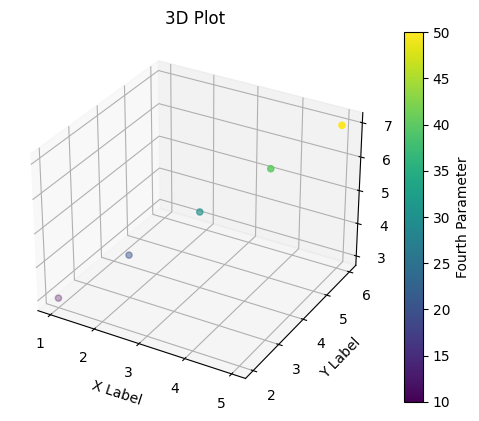

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data (replace with your actual data)
x = [1, 2, 3, 4, 5]  # Values for the first parameter
y = [2, 3, 4, 5, 6]  # Values for the second parameter
z = [3, 4, 5, 6, 7]  # Values for the third parameter
c = [10, 20, 30, 40, 50]  # Values for the fourth parameter (data to plot)

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the data
scatter = ax.scatter(x, y, z, c=c, cmap='viridis')

# Add labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('3D Plot')

# Add color bar
plt.colorbar(scatter, label='Fourth Parameter')

# Show plot
plt.show()

C:\Users\Acer\AppData\Local\Temp\ipykernel_9276\3040613769.py:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='4th Parameter')


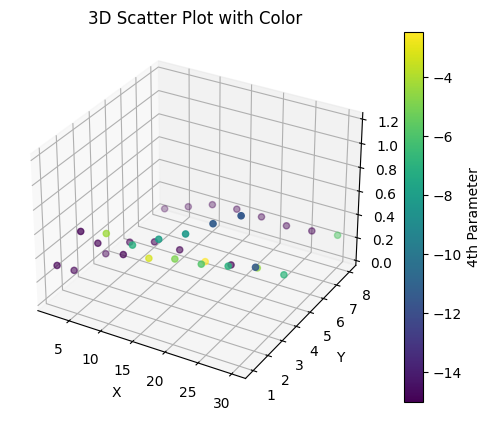

In [59]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

# Define the values for x, y, and the 4th parameter
x_values = np.array([2,6,10,14,18,22,26,30])
y_values = np.array([1, 2, 4, 8])

# Generate the grid of x and y coordinates
X, Y = np.meshgrid(x_values, y_values)

# Define the z values (32 points for each x, y pair)
z_values = mus  # Example z values, replace with your actual data

# Define the 4th parameter values (32 points for each x, y pair)
parameter_values = L  # Example parameter values, replace with your actual data

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the scatter points
scatter = ax.scatter(X, Y, z_values, c=parameter_values, cmap='viridis')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('3D Scatter Plot with Color')

# Create a ScalarMappable object for the color bar
sm = cm.ScalarMappable(cmap='viridis')
sm.set_array(parameter_values)
plt.colorbar(sm, label='4th Parameter')

# Show plot
plt.show()

In [64]:
d, p, b = randoms(n = 18, moran_steps = 4, num_of_sim = 1000)

randoms1 = deque([[x] for x in d])
randoms2 = deque(p)
randoms3 = deque(b)
tree_13_res = np.zeros(15)
tree_14_res = np.zeros(15)

for i in range(1000):
    sim = DFS(node = newick.loads(newick_tree)[0], n = 18, last_node_name = [None], last_node_children_number = [1], brain_list = [], starter_list = [[[]]*18,[], 1], results = [], end_of_branch = [], moran_steps_in_a_year = 4, mutation_number_expected_value = 0.24509804, rds = randoms1, rds_prop = randoms2, rds_bud = randoms3)
    sim.pop()
    tree_14_mut = [rd.choice(sim[0]), rd.choice(sim[1]), rd.choice(sim[2]), rd.choice(sim[3])]
    tree_13_mut = [rd.choice(sim[4]), rd.choice(sim[5]), rd.choice(sim[6]), rd.choice(sim[7])]
    tree_14_res += np.array(fun(tree_14_mut))
    tree_13_res += np.array(fun(tree_13_mut))

avg_tree_14 = tree_14_res/1000
avg_tree_13 = tree_13_res/1000

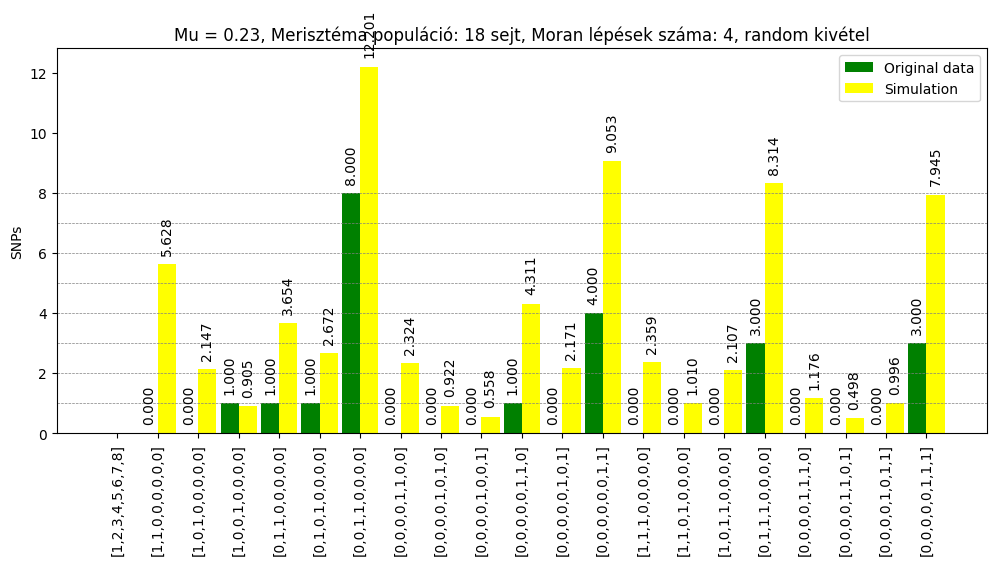

In [68]:
plotting(avg_tree_14, avg_tree_13)

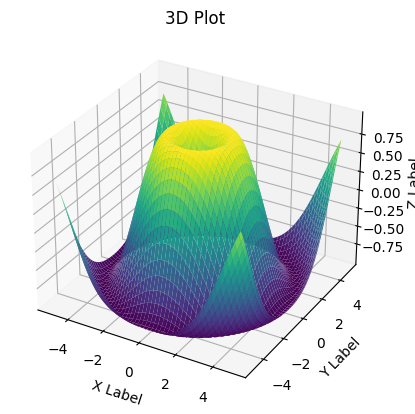

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example data
X = np.array([2,6,10,14,18,22,26,30])
Y = np.array([1, 2, 4, 8])
X, Y = np.meshgrid(x, y)
Z = mus
C = L  # Example 4th parameter values

# Create a 3D plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the surface with colormap
surf = ax.plot_surface(X, Y, Z, cmap='viridis', facecolors=plt.cm.viridis(C))

# Set labels and title
ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')
plt.title('3D Plot with 4th Parameter')

# Add color bar
plt.colorbar(surf, label='4th Parameter')

# Show plot
plt.show()

In [42]:
#print(final_tree_14)
fs = []
for i in range(8):
    fs.append(np.array(pairing(final_tree_14[i], final_tree_13[i])[1::]))
#f = np.array(pairing(final_tree_14, final_tree_13)[1::])
print(np.array(fs))
f = sum(np.array(fs).transpose())
print(f)
k_i = np.array([0, 0, 1, 1, 1, 8, 0, 0, 0, 1, 0, 4, 0, 0, 0, 3, 0, 0, 0, 3])
mus = np.zeros(8)
#print(f[0]/sum(k_i))
mus = sum(k_i)/f
print(mus[0]) 

logL = []
#for i in range(4):
#    for j in range(8):
#    logL.append(loglikelihood(mus[1], np.array(fs)[1], k_i ))
#print(l)

IndexError: index 8 is out of bounds for axis 0 with size 8

In [111]:
print(np.array(fs)[0])

[ 0.     0.     0.     0.     0.    18.109  0.     0.     0.     0.
  0.    13.91   0.     0.     0.    16.116  0.     0.     0.    20.597]


In [112]:
l = loglikelihood(mus[1], np.array(fs)[1], k_i )
print(l)

-0.16390376307001375


In [106]:
a = np.array([1,2,1,2,1,2])
b = np.array([1,3,2,1,2,5])
print(np.log(b))
print(3*b)

[0.         1.09861229 0.69314718 0.         0.69314718 1.60943791]
[ 3  9  6  3  6 15]
